In [1]:
!pip install transformers torch pandas matplotlib tqdm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from transformers import pipeline

c:\Users\vikas\anaconda3\envs\denoisingaudio\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../data/constitution_chunks.csv")
df = df[df["sentence"].str.len() > 50].reset_index(drop=True)

df.head()


,sentence
0,"£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ [1 , 2024 ] THE CONST..."
1,"In this edition, the text of the Constitution ..."
2,The foot notes below the text indicate the Con...
3,The Constitution (One Hundredth Amendment) Act...
4,The Constitution (Application to Jammu and Kas...


Define Constitutional Categories

These are human-interpretable, legally meaningful categories.

In [4]:
CANDIDATE_LABELS = [
    "Fundamental Rights",
    "Fundamental Duties",
    "Judiciary",
    "Union Government",
    "State Government",
    "Amendment Procedure",
    "Elections and Representation",
    "Emergency Provisions",
    "Administrative Provisions"
]


Load Zero-Shot Classification Pipeline

We use BART MNLI, the gold standard for zero-shot tasks.

In [5]:
device = 0 if torch.cuda.is_available() else -1

classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cpu


Classify Sentences

In [6]:
MAX_SAMPLES = 500 ##limit to first 500 sentences for speed

sentences = df["sentence"].tolist()[:MAX_SAMPLES]

predicted_labels = []
predicted_scores = []

for s in tqdm(sentences):
    result = classifier(s, CANDIDATE_LABELS)
    predicted_labels.append(result["labels"][0])
    predicted_scores.append(result["scores"][0])


100%|██████████| 500/500 [39:12<00:00,  4.70s/it]


In [7]:
classified_df = pd.DataFrame({
    "sentence": sentences,
    "predicted_category": predicted_labels,
    "confidence": predicted_scores
})

classified_df.head()


,sentence,predicted_category,confidence
0,"£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ [1 , 2024 ] THE CONST...",Judiciary,0.418069
1,"In this edition, the text of the Constitution ...",Amendment Procedure,0.336996
2,The foot notes below the text indicate the Con...,Amendment Procedure,0.729357
3,The Constitution (One Hundredth Amendment) Act...,Amendment Procedure,0.287467
4,The Constitution (Application to Jammu and Kas...,Amendment Procedure,0.225430


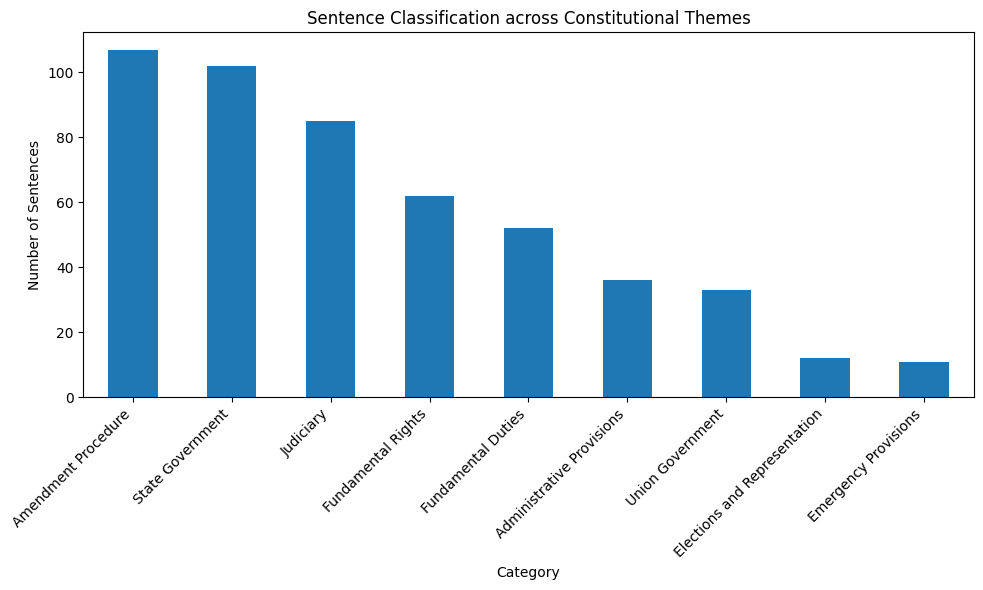

In [8]:
category_counts = classified_df["predicted_category"].value_counts()

plt.figure(figsize=(10,6))
category_counts.plot(kind="bar")
plt.xlabel("Category")
plt.ylabel("Number of Sentences")
plt.title("Sentence Classification across Constitutional Themes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Confidence Score Analysis (Evaluation Metric)

Zero-shot models output probabilities →  evaluation.

In [9]:
classified_df["confidence"].describe()


count    500.000000
mean       0.394127
std        0.188451
min        0.136801
25%        0.244287
50%        0.333543
75%        0.502274
max        0.939609
Name: confidence, dtype: float64

In [10]:
#Inspect High-Confidence Predictions (Interpretability)
classified_df.sort_values(
    by="confidence",
    ascending=False
).head(10)


,sentence,predicted_category,confidence
354,6 7 THE CONSTITUTION OF INDIA (Part III.—Funda...,Fundamental Rights,0.939609
346,Laws inconsistent with or in derogation of the...,Fundamental Rights,0.936377
375,9 THE CONSTITUTION OF INDIA (Part III.—Fundame...,Fundamental Rights,0.931371
28,Laws inconsistent with or in derogation of the...,Fundamental Rights,0.913319
362,8 THE CONSTITUTION OF INDIA (Part III.—Fundame...,Fundamental Rights,0.912669
312,SIXTH SCHEDULE— Provisions as to the Administr...,Administrative Provisions,0.903644
475,20 THE CONSTITUTION OF INDIA (Part III.—Fundam...,Fundamental Rights,0.895241
465,19 THE CONSTITUTION OF INDIA (Part III.—Fundam...,Fundamental Rights,0.887890
418,14 THE CONSTITUTION OF INDIA (Part III.—Fundam...,Fundamental Rights,0.886592
386,10 THE CONSTITUTION OF INDIA (Part III.—Fundam...,Fundamental Rights,0.885864


In [11]:
classified_df.to_csv("../data/constitution_sentence_classification.csv", index=False)
